In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import importlib

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

from tqdm import tqdm
import io, sys
from contextlib import redirect_stdout, redirect_stderr

import os

import h5py
import hdf5plugin

import sys
sys.path.append('./XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')
XPCS.set_expvar(Nx//2, Ny//2, 7)

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA_pre/'
masks_folder = '../masks/'

### Load old masks

In [3]:
mask_ht_2023 = np.load(masks_folder+'e4m_htmask_8,67keV'+'.npy')
e4m_mask = np.load(masks_folder+'e4m_mask'+'.npy')

# Generation of the e4m detector mask

This shuld account for all issues related only to the campera, i.e less or more sensitive areas, dead pixels, etc.

## Load a very long scan for the analysis (=> high signal)...

### Load 1st copper foil scan (copper_foil_30um, 1, 1)

In [4]:
#######################################
sample_name = 'copper_foil_30um'
Ndataset = 1
Nscan = 1
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
itime = scan['itime']
theta = scan['delcoup']

print('#############################')
print('command =', scan['command'])
print('itime =', itime)
print('theta =', theta)
print('#############################\n')

len_dataset_string =ID10.len_dataset_string
df_eiger4m_entry = ID10.df_eiger4m_entry

# LOAD MASTER DATASET FILE
e4m_file = raw_folder + sample_name+'/' +sample_name+'_'+str(Ndataset).zfill(len_dataset_string)+'/' + sample_name+'_'+str(Ndataset).zfill(len_dataset_string)+'.h5'
h5file = h5py.File(e4m_file, 'r')[str(Nscan)+'.1']

# LOAD EIGER4M DF LINK
df = h5file['measurement'][df_eiger4m_entry]

#############################
command = ftimescan 0.1 36000 0
itime = 0.100106
theta = 0.0
#############################



### Average the hull scan

In [5]:
do_avg = False

if do_avg:
    NfXloop = 100
    X = np.zeros(Npx)
    Nloop_i = 0
    Nloop_f = 24000//NfXloop

    for i in tqdm(range(Nloop_i, Nloop_f)):
        Nfi = i*NfXloop
        Nff = (i+1)*NfXloop
        e4m_data = sparse.csr_array(df[Nfi:Nff].reshape(Nff-Nfi, Npx))
        X += e4m_data.sum(axis=0)

    X = X/((Nloop_f-Nloop_i)*NfXloop*itime)

    np.save('./copper_mask_out/avg_scan1_A.npy', X)

    NfXloop = 100
    X = np.zeros(Npx)
    Nloop_i = 24000//NfXloop
    Nloop_f = 36000//NfXloop

    for i in tqdm(range(Nloop_i, Nloop_f)):
        Nfi = i*NfXloop
        Nff = (i+1)*NfXloop
        e4m_data = sparse.csr_array(df[Nfi:Nff].reshape(Nff-Nfi, Npx))
        X += e4m_data.sum(axis=0)

    X = X/((Nloop_f-Nloop_i)*NfXloop*itime)

    np.save('./data/copper_mask_out/avg_scan1_B.npy', X)

avg_scan1_A = np.load('./data/copper_mask_out/avg_scan1_A.npy')
avg_scan1_B = np.load('./data/copper_mask_out/avg_scan1_B.npy')

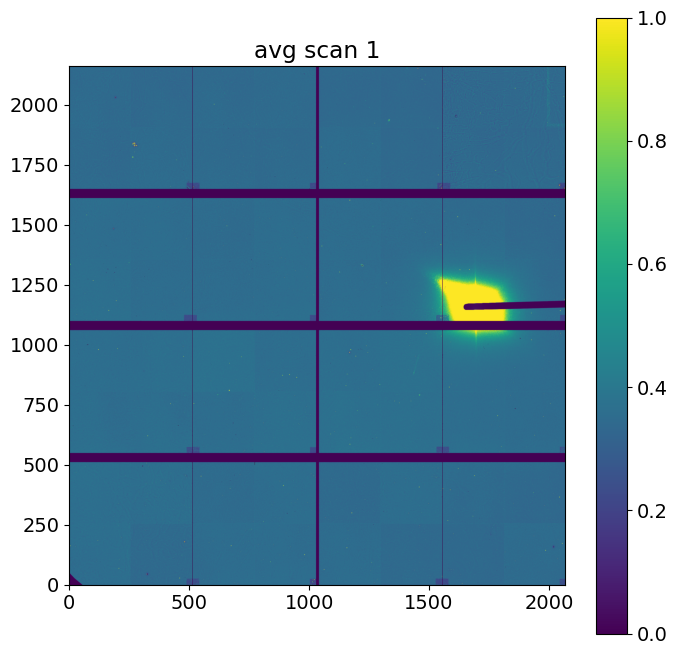

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(avg_scan1_A.reshape(Nx, Ny), vmin=0, vmax=1, origin='lower')
plt.colorbar()
plt.title('avg scan 1')
plt.show()

### Load part of the copper foil data

In [7]:
#############
Nfi = 0
Nff = 1000
#############

e4m_data = sparse.csr_array(df[Nfi:Nff].reshape(Nff-Nfi, Npx))

### Intensity stability by time

In [8]:
Idt = e4m_data[:, e4m_mask].sum(axis=1)

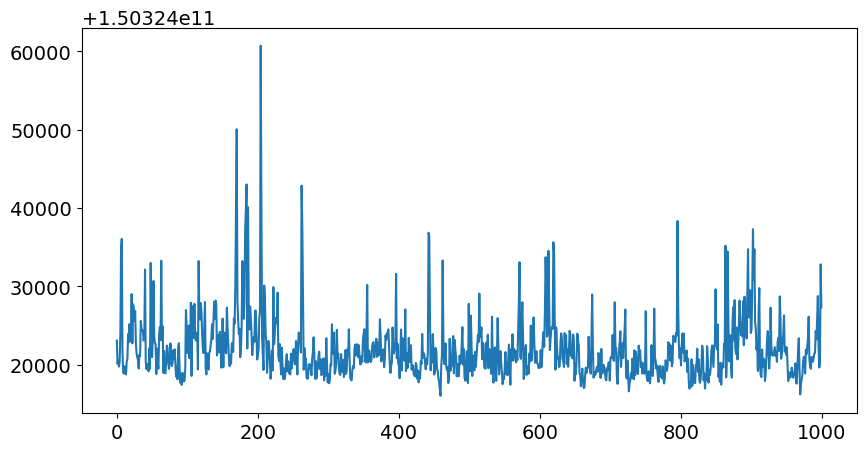

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(Idt)

### First look

################################################################################
Maximum count in the hull run -> 4294967295
# of pixels above Ith_high treshold ->  49665 pixels (of 4471016 => 1.11 %)
# of pixels above Imaxth_high treshold ->  5609 pixels (of 4471016 => 0.13 %)
################################################################################



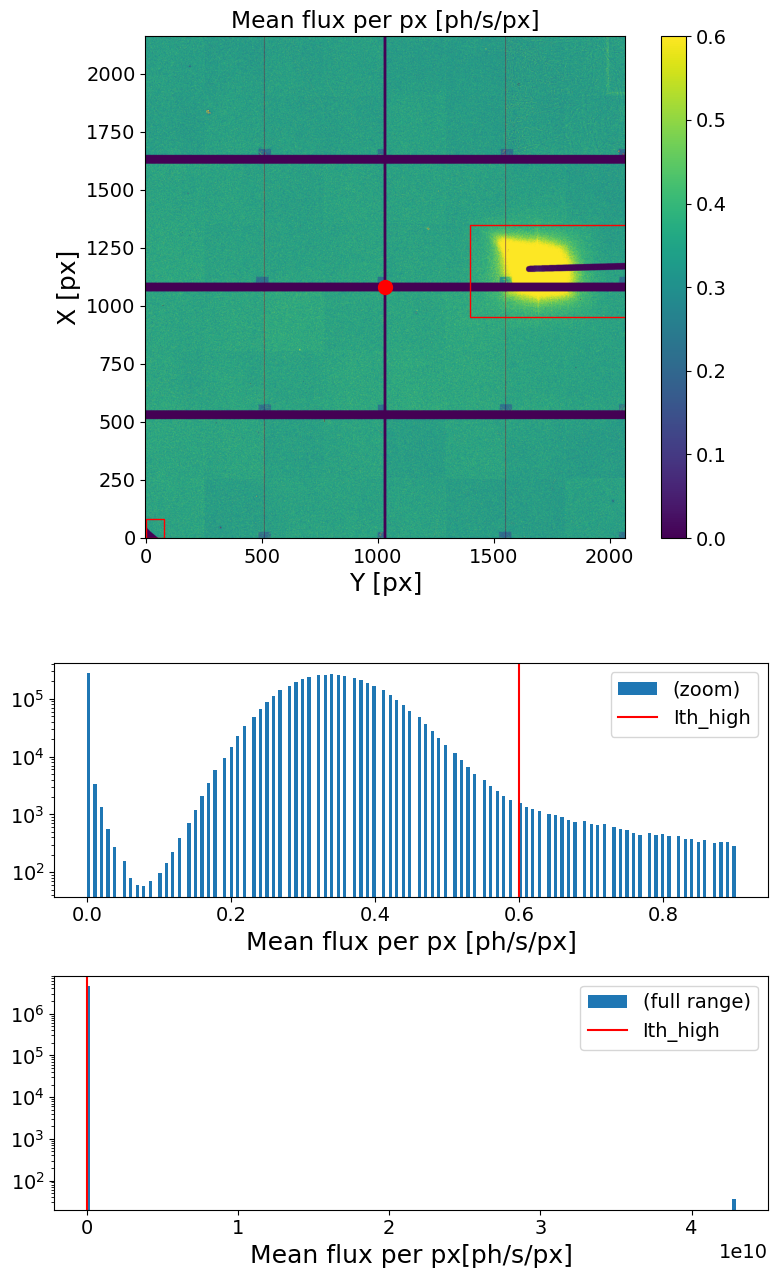

In [10]:
geom = [{'geom':'Rectangle', 'x0':950, 'y0':1400, 'xl':400, 'yl':1000, 'inside':False},
        {'geom':'Rectangle', 'x0':0, 'y0':0, 'xl':80, 'yl':80, 'inside':False}    
        ]

XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.6, Imaxth_high=5, e4m_mask=None, mask_geom=geom, Nfi=0, Nff=None, max_plots=False, wide_plots=True)

#################################################
Masked area =  93.86204388443254 %
#################################################



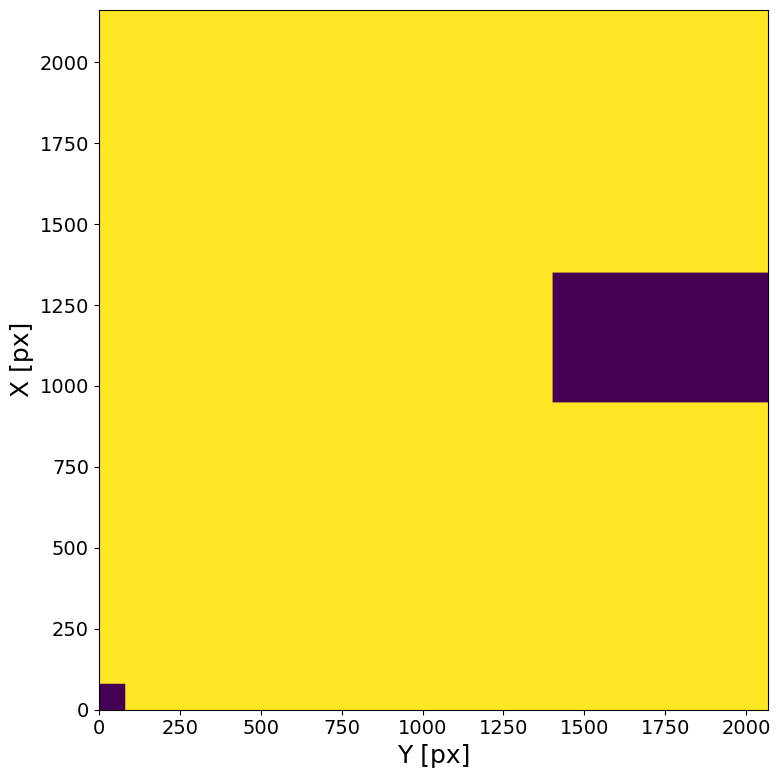

In [11]:
bs_mask = XPCS.gen_mask(e4m_data, itime, e4m_mask=None, mask_geom=geom, hist_plots=False)

## 1) Manual selection of areas of the detector

Use the flux and max maps with tight tresholds to underline the unwanted ares of the detector. Here we are looking for all kind of lines or strange large areas in the detector.
Use %matplotlib qt and high Nff to look at the maps!

### 1.1) Flux and max maps


################################################################################
Maximum count in the hull run -> 4294967295
# of pixels above Ith_high treshold ->  21916 pixels (of 4471016 => 0.49 %)
# of pixels below Ith_low treshold ->  280950 pixels (of 4471016 => 6.28 %)
# of pixels above Imaxth_high treshold ->  8026 pixels (of 4471016 => 0.18 %)
################################################################################



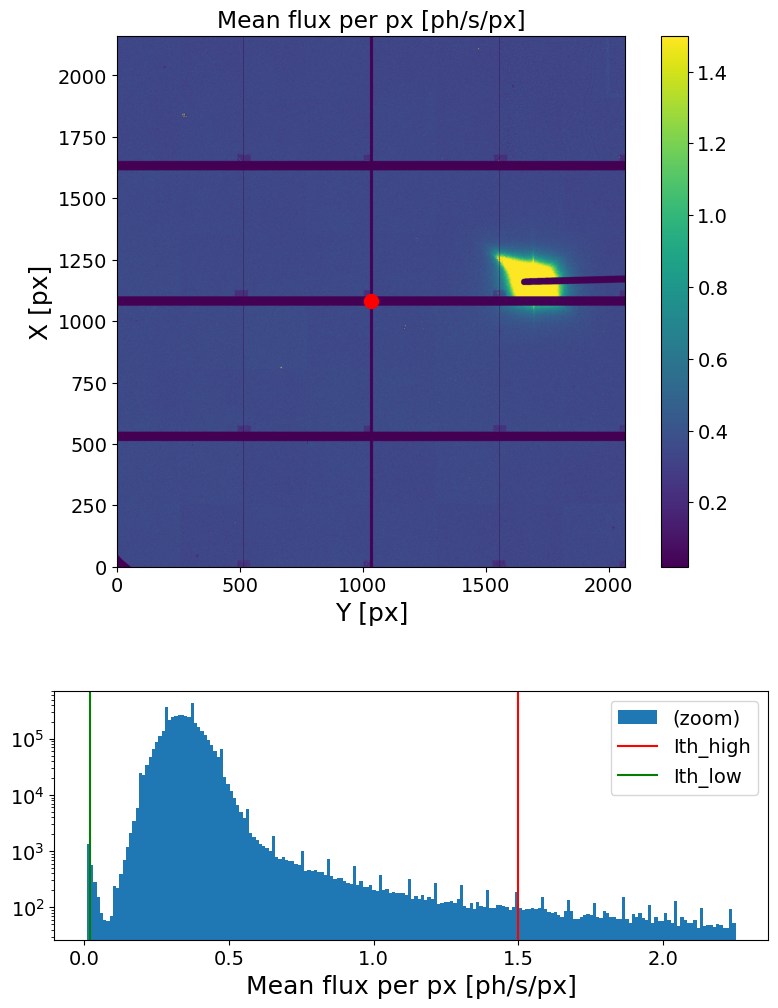

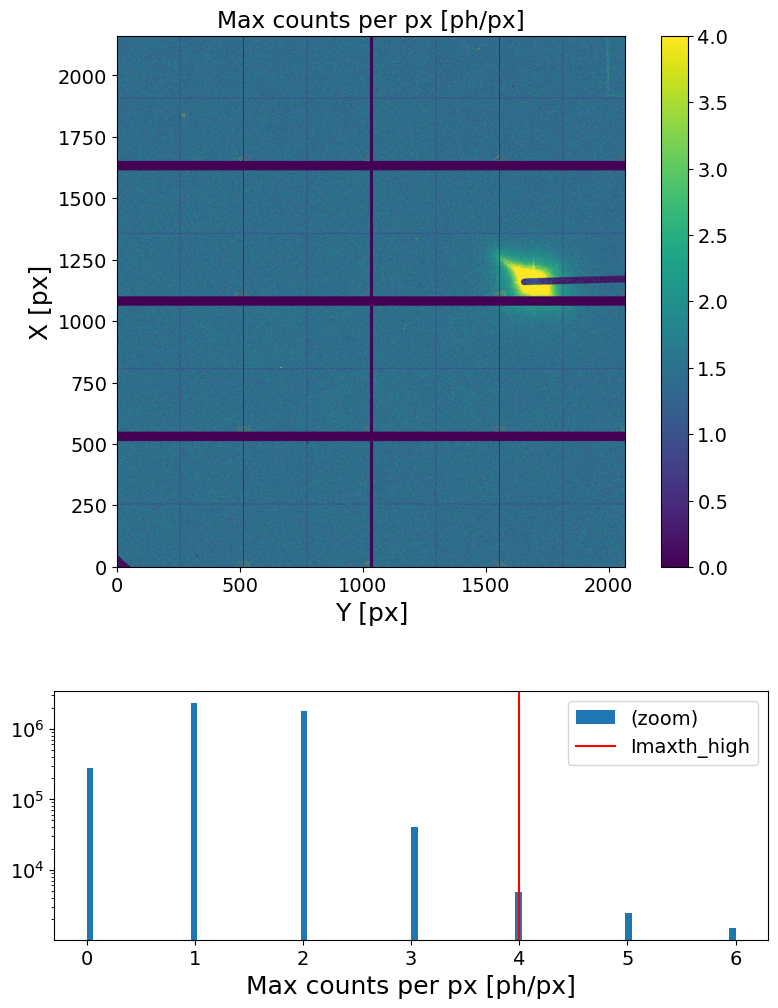

In [12]:
########################
Ith_low = .02
Ith_high = 1.5
Imaxth_high = 4
########################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high, Ith_low=Ith_low, Imaxth_high=Imaxth_high, Nfi=Nfi, Nff=Nff, wide_plots=False, max_plots=True)

### 1.2) MIN map remove hot pixels

In [13]:
MIN_map = e4m_data.min(axis=0).toarray().reshape(Nx, Ny)

In [14]:
# get idx of of pixels that MIN_map!=0
idx = np.where(MIN_map!=0)
idx = np.hstack((idx[0].reshape(-1,1), idx[1].reshape(-1,1)))

### 1.3) Mask manual definition

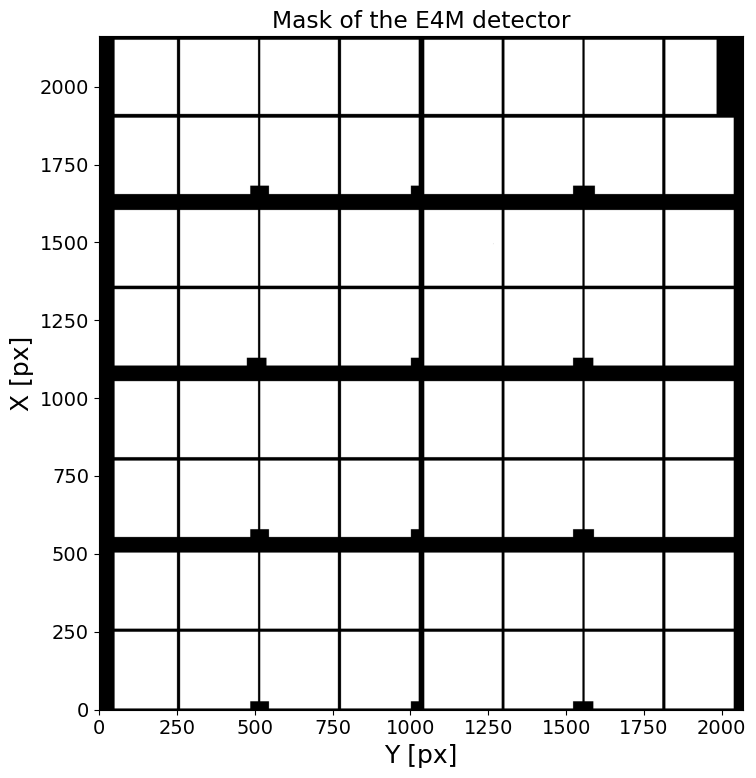

In [15]:
######## MASK OF LINES OF E4M DETECTOR ##########
e4m_mask = np.ones((Nx, Ny), dtype=bool)

# mask columns
e4m_mask[:, 510:517] = False
e4m_mask[:, 1025:1043] = False
e4m_mask[:, 1550:1557] = False

# mask rows
e4m_mask[505:555, :] = False
e4m_mask[1055:1105, :] = False
e4m_mask[1604:1655, :] = False

# mask borders
e4m_mask[:5, :] = False
e4m_mask[2150:, :] = False
e4m_mask[:, :50] = False
e4m_mask[:, 2035:] = False

# thin mask rows and columns at the center of the squares (visbile trhought max plots)
e4m_mask[251:261, :] = False
e4m_mask[800:811, :] = False
e4m_mask[1350:1361, :] = False
e4m_mask[1900:1912, :] = False

e4m_mask[:, 250:260] = False
e4m_mask[:, 766:776] = False
e4m_mask[:, 1291:1300] = False
e4m_mask[:, 1806:1816] = False
e4m_mask
# rectangles at the cross of row-columns borders
e4m_mask[:28,       485:545] = False
e4m_mask[540:580,   485:545] = False
e4m_mask[1090:1130, 474:537] = False
e4m_mask[1645:1682, 485:545] = False

e4m_mask[:28,       1000:1040] = False
e4m_mask[540:580,   1000:1040] = False
e4m_mask[1090:1130, 1000:1040] = False
e4m_mask[1645:1682, 1000:1040] = False

e4m_mask[:28,       1520:1585] = False
e4m_mask[540:580,   1520:1587] = False
e4m_mask[1090:1130, 1520:1585] = False
e4m_mask[1645:1682, 1520:1590] = False


# mask upright corner
e4m_mask[1900:, 1980:] = False

# remove higher-left rectangle
#e4m_mask[1640:, 1550:] = False

# remove single broken pixels
e4m_mask[15, 1007] = False
e4m_mask[15, 1008] = False
e4m_mask[16, 1008] = False
e4m_mask[1495, 1264] = False


e4m_mask = e4m_mask.flatten()
#################################################

# show the result
plt.figure(figsize=(8,8))
plt.imshow(e4m_mask.reshape(Nx, Ny), cmap='gray', origin='lower')
plt.title('Mask of the E4M detector')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

# save e4m_mask
np.save(masks_folder+'e4m_mask', e4m_mask)

### 1.4) Result on the same scan

################################################################################
Maximum count in the hull run -> 4294967295
# of pixels above Ith_high treshold ->  20962 pixels (of 4471016 => 0.57 %)
# of pixels below Ith_low treshold ->  9670 pixels (of 4471016 => 0.26 %)
# of pixels above Imaxth_high treshold ->  46127 pixels (of 4471016 => 1.24 %)
################################################################################



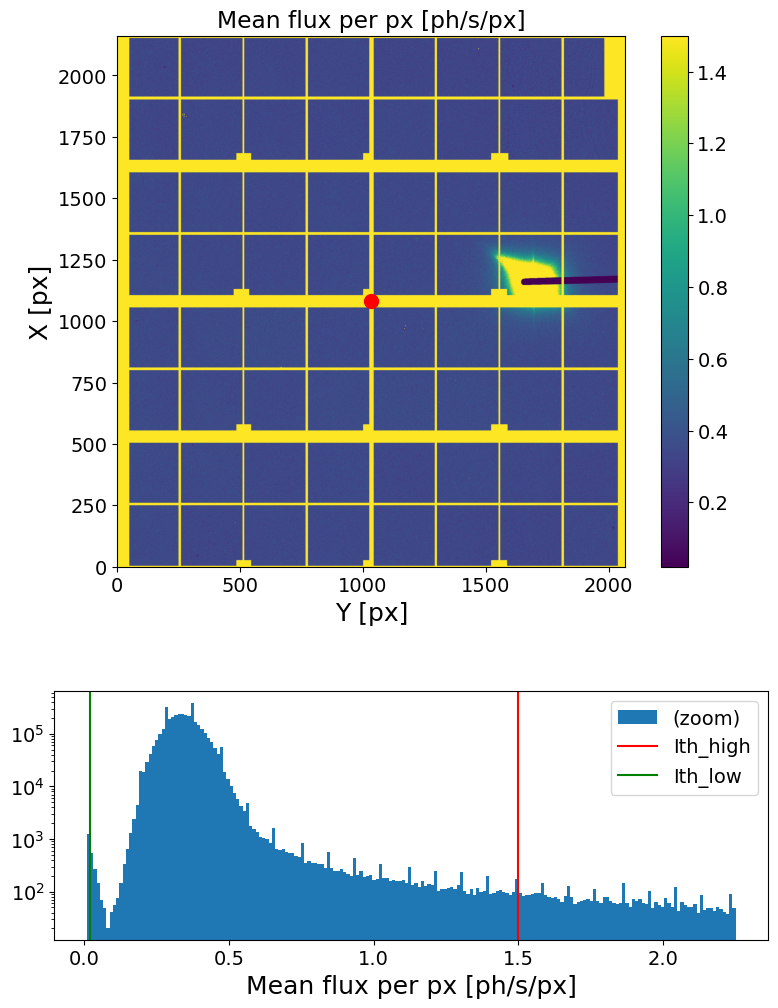

In [16]:
########################
Ith_low = .02
Ith_high = 1.5
Imaxth_high = 2
########################wrong

XPCS.gen_plots4mask(e4m_data, itime, Ith_high, Ith_low=Ith_low, Imaxth_high=Imaxth_high, e4m_mask=e4m_mask, Nfi=Nfi, Nff=Nff, wide_plots=False, max_plots=False)


## 2) Hot/cold/non-flat pixels

Use strong treshold on the flux per px histogram around the signal distribution (in lin scale) to decouple the signal from the distribution of other noisy pixels.

Use the central 4/6 of the run, to test the hard treshold mask on the latter (skip the first to let the intensity stabilize because of the damage).


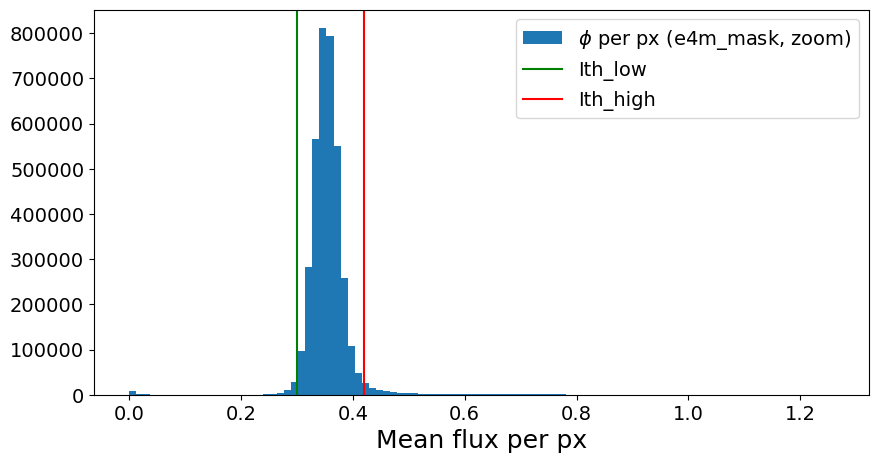

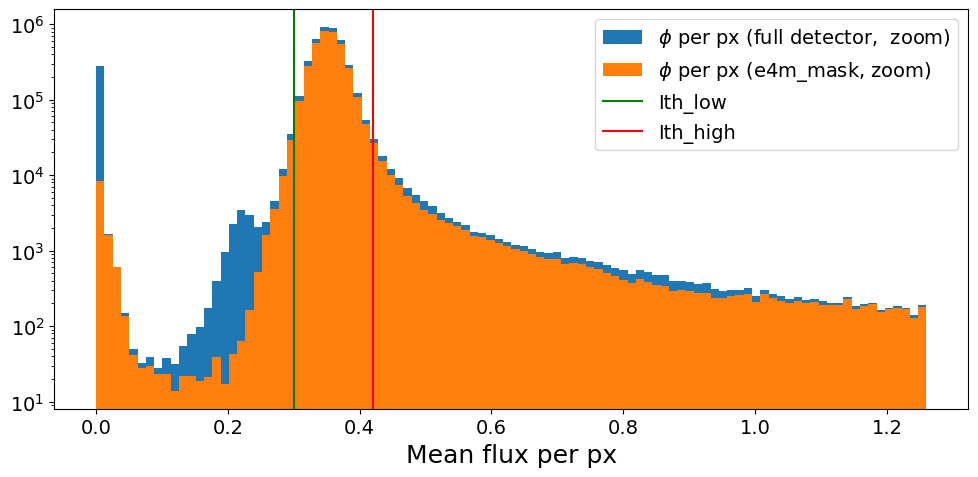

In [17]:
########################
Ith_high = 0.42
Ith_low  = 0.3
########################

plt.figure(figsize=(10, 5))
plt.hist(avg_scan1_A[e4m_mask], bins=100, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.xlabel('Mean flux per px')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(avg_scan1_A,           bins=100, range=(0, Ith_high*3), label='$\\phi$ per px (full detector,  zoom)')
plt.hist(avg_scan1_A[e4m_mask], bins=100, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout()
plt.show()



#### Higher trehsold map

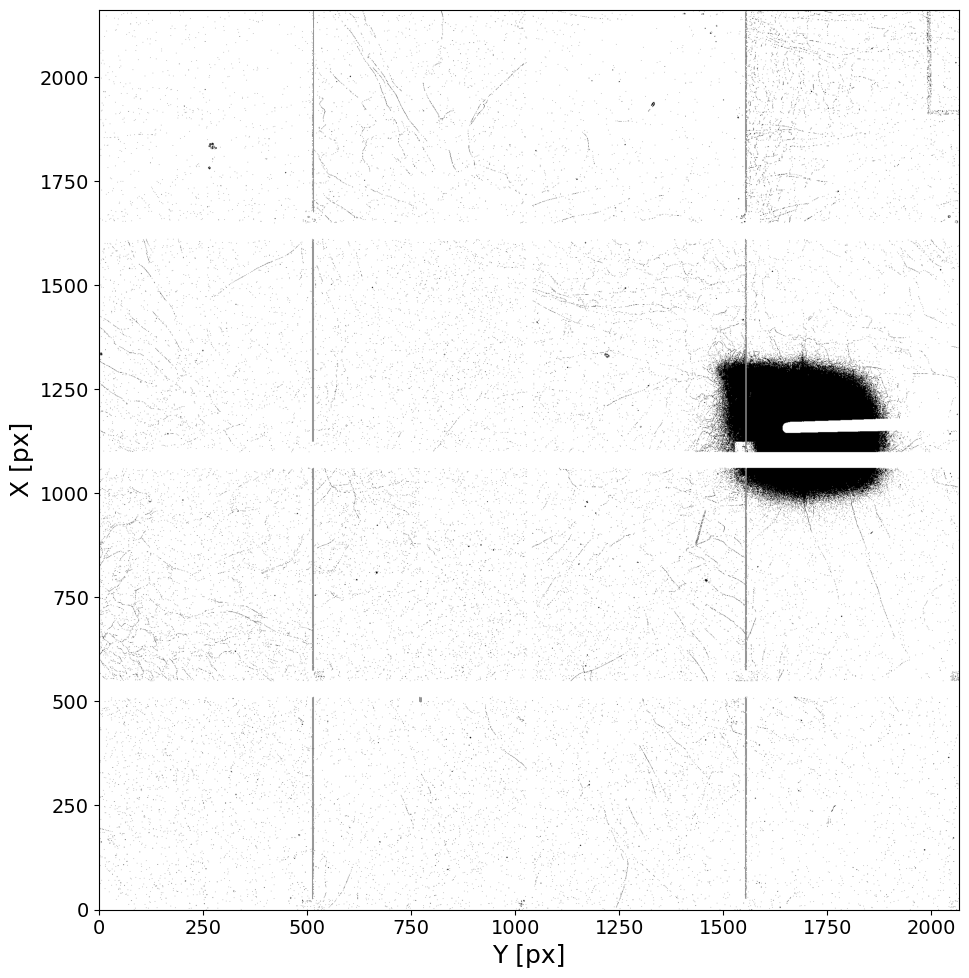

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(~(avg_scan1_A>Ith_high).reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

#### Lower threshold map

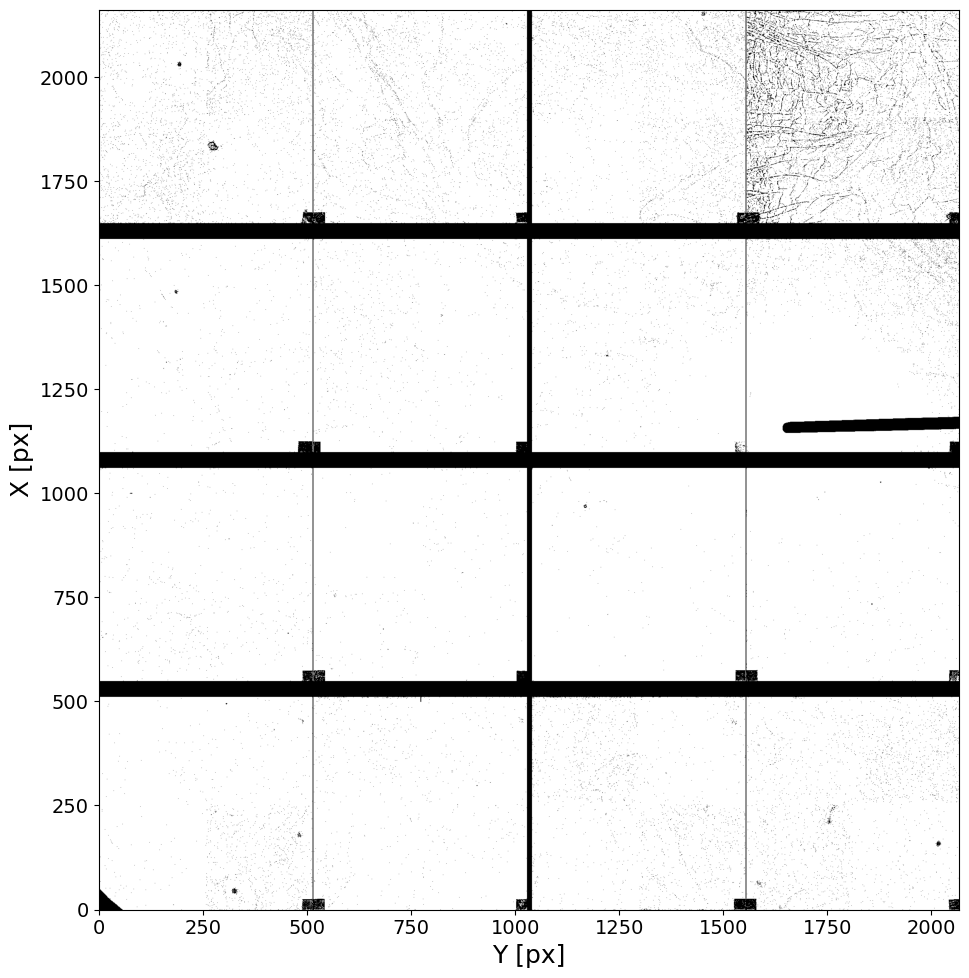

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(~(avg_scan1_A<Ith_low).reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

In [20]:
e4mht_mask = (avg_scan1_A>Ith_low) * (avg_scan1_A<Ith_high)
np.save(masks_folder  + 'e4m_htmask_copper_foil_30um_1_1.npy', e4mht_mask)

print('Percentage of pixels masked (where e4m_mask=True) =', (e4m_mask.sum()-(e4mht_mask*e4m_mask).sum())/e4m_mask.sum()*100)

Percentage of pixels masked (where e4m_mask=True) = 4.5670191930638655


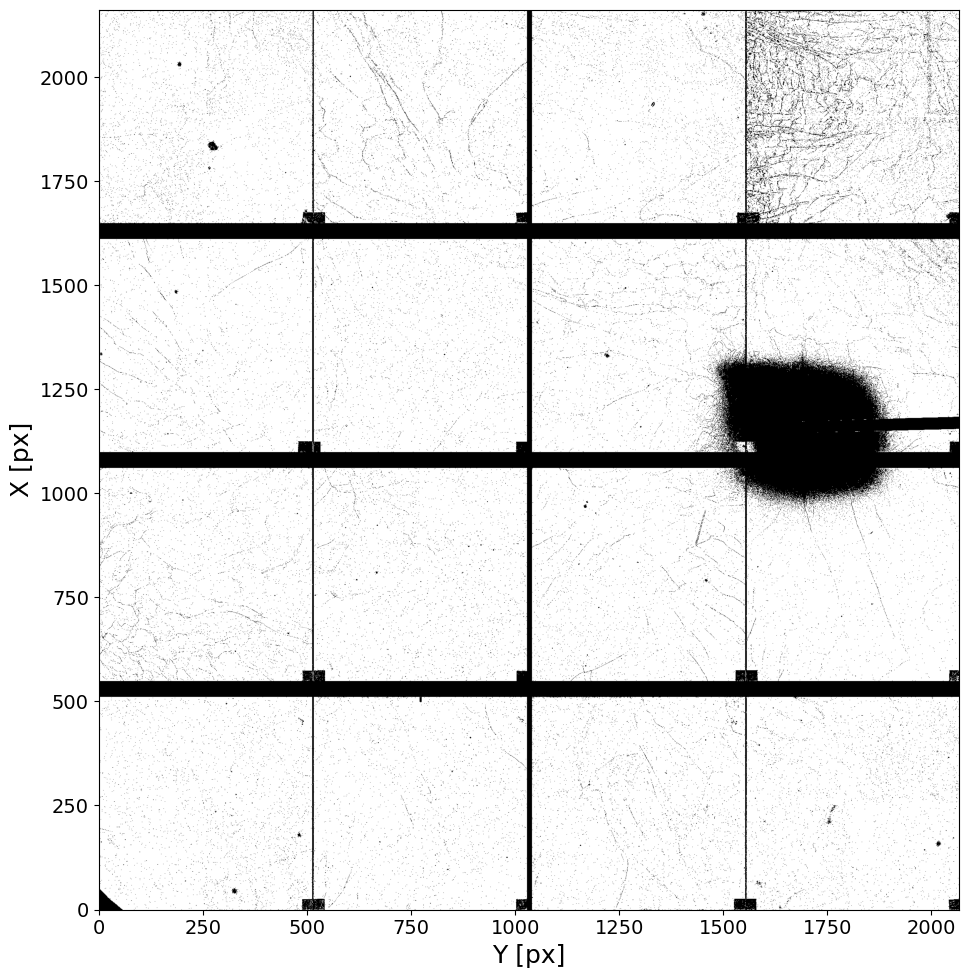

In [21]:
plt.figure(figsize=(10, 10))

plt.imshow(e4mht_mask.reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

### 2.3) Check result on the last part of the scan

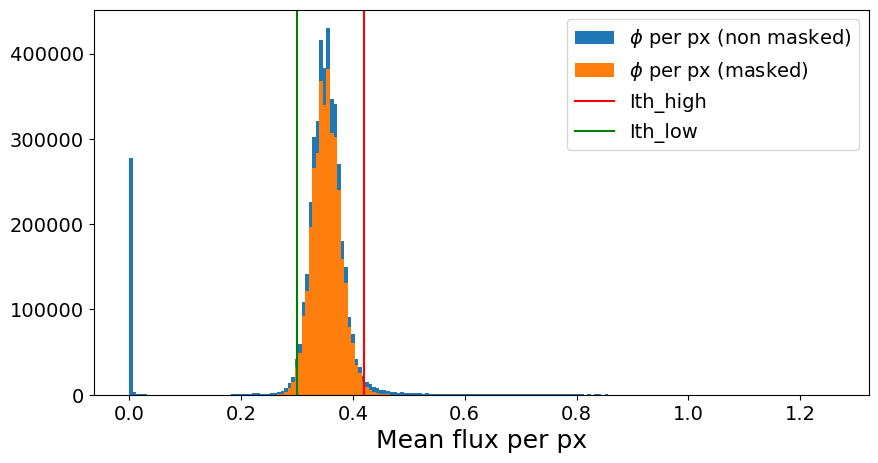

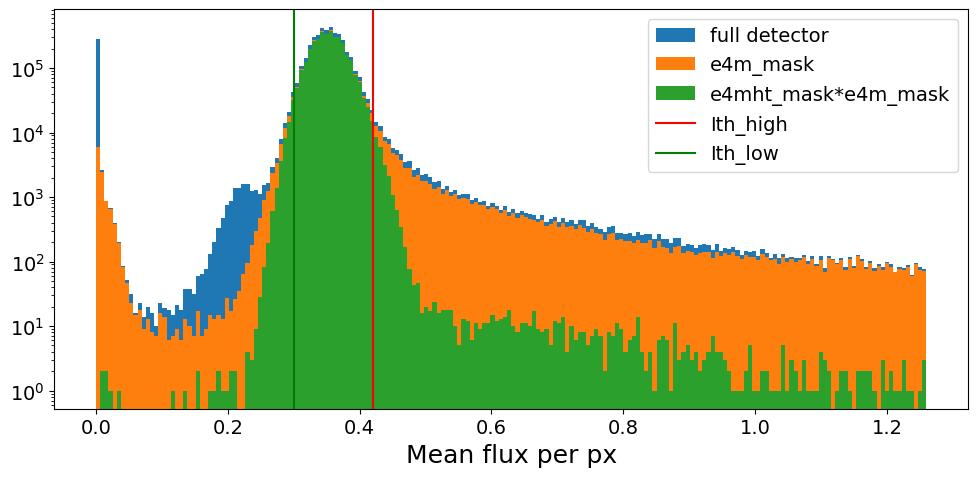

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(avg_scan1_B, bins=200, range=(0, Ith_high*3), label='$\\phi$ per px (non masked)')
plt.hist(avg_scan1_B[e4m_mask*e4mht_mask], bins=200, range=(0, Ith_high*3), label='$\\phi$ per px (masked)')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.xlabel('Mean flux per px')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(avg_scan1_B,                      bins=200, range=(0, Ith_high*3), label='full detector')
plt.hist(avg_scan1_B[e4m_mask],            bins=200, range=(0, Ith_high*3), label='e4m_mask')
plt.hist(avg_scan1_B[e4m_mask*e4mht_mask], bins=200, range=(0, Ith_high*3), label='e4mht_mask*e4m_mask')

plt.axvline(Ith_high, color='r', label='Ith_high')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout()
#plt.savefig('./figures/e4mht_mask_hist.png')
plt.show()